In [1]:
import random
import math
import operator
import matplotlib.pyplot as plt
import time

In [2]:
class Graph(object):
    def __init__(self, distances: list, rank: int):
        self.distances = distances
        self.rank = rank
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]


### Graph
Wrapper class which holds general information about cities such as:
 - <strong>distances</strong>: Matrix of distance between each city.
 - <strong>rank</strong>: Number of cities, all cities are interconnected.
 - <strong>pheromone</strong>: Matrix of pheromone level between cities.

In [3]:
class ACS(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int):
        self.generations = generations
        self.ant_count = ant_count
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = q        

### ACS
Ant Colony System is a system which will be used to solve $TSP$ problem with $ACO$ optimization.
 - <strong>generations</strong>: Number of generations that will be created.
 - <strong>ant_count</strong>: Number of ants that will be created in each generation.
 - <strong>alpha</strong>: Positive metaparameter which determines phermone influence.
 - <strong>beta</strong>: Positive metaparameter which determines distance influence.
 - <strong>rho</strong>: Positive metaparameter in range(0, 1).
 - <strong>Q</strong>: Positive metaparameter.
 

In [4]:

def update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                sum_ants_pheromone_delta = 0
                for ant in ants:
                    sum_ants_pheromone_delta += ant.pheromone_delta[i][j]
                graph.pheromone[i][j] = (1 - self.rho) * graph.pheromone[i][j] + sum_ants_pheromone_delta
                
ACS.update_pheromone = update_pheromone

### Updating pheromone
Method which updates matrix of pheromone levels between each city by using formulas:

$$t_{i,j} = (1-\rho) * t_{i,j} + \Delta t_{i,j}$$

$$\Delta t_{i,j}  = \sum_{k=1}^{m} \Delta t^k_{i,j}$$



In [5]:

def solve(self, graph: Graph):
        best_cost = float('inf')
        best_solution = []
        for _ in range(self.generations):
            ants = [Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant.select_next_node()
                ant.total_cost += graph.distances[ant.visited_nodes[-1]][ant.visited_nodes[0]]
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.visited_nodes
                ant.update_pheromone_delta()
            self.update_pheromone(graph, ants)
        return best_solution, best_cost
    
ACS.solve = solve

### Solve
Method which finds best solution and best traverse cost for solving TSP on given graph.

It creates specified number of generations and within each generation specified number of ants. 
These ants are traversing through entire Graph, visiting each Node only once. In the process ants are storing total traverse cost and order of visited nodes.
In the end each ant is updating it's pheromone_delta which will be used for updating pheromone level in entire system.

After each generation paths which were frequently traversed by ants will have larger amounts of pheromone.

In [6]:
class Ant(object):
    def __init__(self, acs: ACS, graph: Graph):
        self.colony = acs
        self.graph = graph
        self.total_cost = 0.0
        self.visited_nodes = []
        self.pheromone_delta = []
        self.unvisited_nodes = [i for i in range(graph.rank)]
        start_node = random.randint(0, graph.rank - 1)
        self.visited_nodes.append(start_node)
        self.current_node = start_node
        self.unvisited_nodes.remove(start_node)


### Ant 

Class which represents ant in system. It contains fields which defer between ants.
 - <strong>colony</strong>: Ant Colony System in which ant is created.
 - <strong>graph</strong>: Graph for which ant is being used.
 - <strong>total_cost</strong>: Distance/cost of path ant traversed.
 - <strong>visited_nodes</strong>: Order in which ant traversed nodes.
 - <strong>pheromone_delta</strong>: Amount of pheromone single ant produces.
 - <strong>unvisited_nodes</strong>: List of nodes ant has not yet visited.
 - <strong>current_node</strong>: Index of node Ant is visiting. Initial node is selected by random.

 


In [7]:

def select_next_node(self):
    denominator = 0
    for i in self.unvisited_nodes:
        denominator += self.graph.pheromone[self.current_node][i] ** self.colony.alpha * \
            self.graph.distances[self.current_node][i] ** (-1 * self.colony.beta )

    probabilities = [0 for i in range(self.graph.rank)]
    for i in range(self.graph.rank):
        try:
            self.unvisited_nodes.index(i)  # test if allowed list contains i
            probabilities[i] = self.graph.pheromone[self.current_node][i] ** self.colony.alpha * \
                self.graph.distances[self.current_node][i] ** (-1 * self.colony.beta) / denominator
        except ValueError:
            pass

    # select next node by probability roulette
    selected_node = 0
    rand = random.random()
    for i, probability in enumerate(probabilities):
        rand -= probability
        if rand <= 0:
            selected_node = i
            break

    self.unvisited_nodes.remove(selected_node)
    self.visited_nodes.append(selected_node)
    self.total_cost += self.graph.distances[self.current_node][selected_node]
    self.current_node = selected_node
    
Ant.select_next_node = select_next_node

### Select next node

Calculates probability for each not yet visited node to be visited by ant. Probability is determined by formula:

$$p_{i,j} = {t_{i,j}^\alpha * distance_{i,j}^{-\beta} \over \sum_{l \in J_k}^{} t_{i,j}^\alpha * distance_{i,j}^{-\beta} }$$

Where $J_k$ is list of not yet visited nodes


In [8]:

def update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.visited_nodes)):
            i = self.visited_nodes[_ - 1]
            j = self.visited_nodes[_]
            self.pheromone_delta[i][j] = self.colony.Q / self.total_cost
            
Ant.update_pheromone_delta = update_pheromone_delta

### Update pheromone delta

Updates ant's pheromone delta by initializing to 0 and only updating it for neighbour nodes by formula:

$$\Delta t^k_{i,j} = Q/L_k$$

Where $L_k$ is traversed distance and $Q$ is metaparameter

In [9]:
def distance(city1: dict, city2: dict):
    return math.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)

In [10]:
def plot(points, path: list):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    # noinspection PyUnusedLocal
    y = list(map(operator.sub, [max(y) for i in range(len(points))], y))
    plt.plot(x, y, 'co',color="red")

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]
        # noinspection PyUnresolvedReferences
        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='black', length_includes_head=True)

    # noinspection PyTypeChecker
    plt.xlim(0, max(x) * 1.1)
    # noinspection PyTypeChecker
    plt.ylim(0, max(y) * 1.1)
    plt.show()

In [11]:
ant_count = 10
generations = 100
alpha = 1.0
beta = 10.0
rho = 0.5
q = 10

cities_144_file_name = "cities-144.txt"
cities_31_file_name = "cities-31.txt"
cities_48_file_name = "cities-48.txt"

In [16]:
def find_optimal_path(file_name):
    cities = []
    points = []
    with open("./data/{}".format(file_name)) as f:
        for line in f.readlines():
            city = line.split(' ')
            cities.append(dict(index=int(city[0]), x=int(city[1]), y=int(city[2])))
            points.append((int(city[1]), int(city[2])))
    distances = []
    number_of_cities = len(cities)
    for i in range(number_of_cities):
        row = []
        for j in range(number_of_cities):
            row.append(distance(cities[i], cities[j]))
        distances.append(row)

    acs = ACS(ant_count, generations, alpha, beta, rho, q)
    graph = Graph(distances, number_of_cities)
    start = time.time()
    path, cost = acs.solve(graph)
    end = time.time()
    
    print('COST: {},\nPATH: {}'.format(cost, path))
    print('TIME EXECUTION: {}'.format(end-start))
    plot(points, path)


COST: 15818.193528359376,
PATH: [13, 12, 11, 10, 22, 15, 4, 5, 6, 1, 3, 7, 8, 9, 2, 17, 16, 18, 23, 24, 19, 20, 21, 25, 27, 26, 29, 30, 28, 0, 14]
TIME EXECUTION: 1.9329426288604736


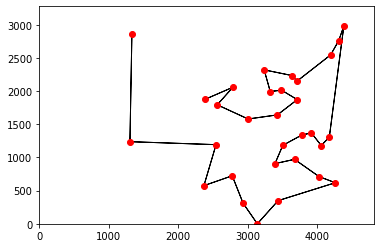

In [18]:
find_optimal_path(cities_31_file_name)

COST: 36472.28403978898,
PATH: [4, 47, 38, 31, 20, 46, 10, 22, 13, 24, 12, 2, 21, 15, 0, 7, 8, 37, 30, 43, 17, 6, 27, 35, 29, 5, 36, 18, 26, 42, 16, 19, 32, 45, 14, 11, 39, 33, 40, 28, 1, 25, 3, 34, 44, 9, 23, 41]
TIME EXECUTION: 4.64718222618103


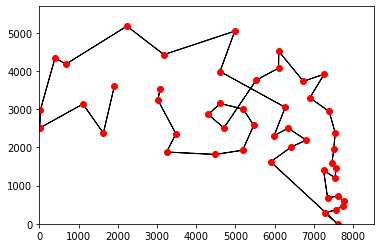

In [19]:
find_optimal_path(cities_48_file_name)

COST: 34785.4084651922,
PATH: [16, 111, 110, 114, 20, 66, 115, 18, 67, 19, 47, 142, 65, 17, 113, 15, 64, 112, 62, 14, 4, 100, 80, 81, 32, 127, 97, 51, 52, 50, 1, 0, 96, 98, 2, 49, 3, 99, 6, 5, 53, 102, 8, 104, 7, 56, 105, 57, 106, 12, 59, 107, 108, 11, 60, 9, 101, 54, 58, 10, 103, 55, 22, 69, 21, 117, 68, 116, 71, 26, 74, 27, 118, 119, 23, 48, 25, 72, 73, 120, 24, 122, 123, 29, 76, 28, 129, 130, 85, 34, 83, 35, 128, 82, 109, 13, 63, 61, 43, 42, 139, 90, 45, 92, 44, 140, 46, 138, 91, 93, 94, 141, 41, 136, 135, 39, 89, 137, 87, 133, 143, 134, 95, 38, 125, 78, 77, 30, 79, 31, 126, 75, 86, 84, 132, 124, 36, 131, 37, 40, 88, 33, 121, 70]
TIME EXECUTION: 49.87340569496155


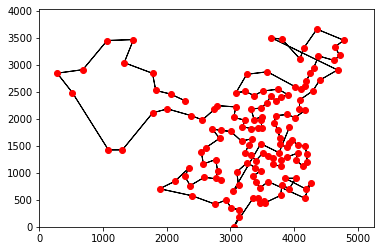

In [20]:
find_optimal_path(cities_144_file_name)